In [95]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models, Input, Model, activations
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, PrecisionRecallDisplay, average_precision_score

from src.mpra_tools.fasta_utils import *

In [69]:
def one_hot_seqs(seqs) -> np.array:
    static_1hotmap = {
        'A' : np.array([1,0,0,0]),
        'a' : np.array([1,0,0,0]),
        'C' : np.array([0,1,0,0]),
        'c' : np.array([0,1,0,0]),
        'G' : np.array([0,0,1,0]),
        'g' : np.array([0,0,1,0]),
        'T' : np.array([0,0,0,1]),
        't' : np.array([0,0,0,1]),
    }
    onehot_seqs = []
    for seq in seqs:
        onehot_seqs.append(
            [static_1hotmap[seq[i]] if seq[i] in static_1hotmap.keys() else static_1hotmap[random.choice(['A','C','G','T'])] for i in range(len(seq))]
        )
    return np.stack(onehot_seqs)


In [70]:
LABEL_KEY = 'open'
data_df = pd.read_csv("Data/ATAC/labeled_data.csv", index_col=0)

test_df = data_df[data_df['set'] == 'TEST']
len(test_df)
x_test = one_hot_seqs(test_df['sequence'])

encoder = LabelEncoder()
encoder.fit(data_df[LABEL_KEY])
classes = encoder.classes_
num_classes = len(classes)
y_test = encoder.transform(test_df[LABEL_KEY])
y_test = keras.utils.to_categorical(y_test, num_classes)


In [71]:
folds = [str(i) for i in range(1,11)]
folder = "ATAC_10660504"
model_name = "cnn_model.keras"

In [72]:
results = []
predictions = []
for fold in folds:
    model = keras.models.load_model(os.path.join(folder,fold,model_name))
    results.append(model.evaluate(x_test,y_test,batch_size=64, verbose=1))
    
    predictions.append(model.predict(x_test, verbose=0))
    
    

126/126 [==============================] - 6s 42ms/step - loss: 0.5330 - accuracy: 0.7885


In [94]:
truths = np.argmax(y_test, axis=1)
preds = [np.argmax(p, axis=1) for p in predictions]
best_fold = 10
print(classification_report(truths,preds[best_fold-1], target_names=classes))

              precision    recall  f1-score   support

      Closed       0.79      0.83      0.81      4363
        Open       0.78      0.74      0.76      3648

    accuracy                           0.79      8011
   macro avg       0.79      0.78      0.79      8011
weighted avg       0.79      0.79      0.79      8011



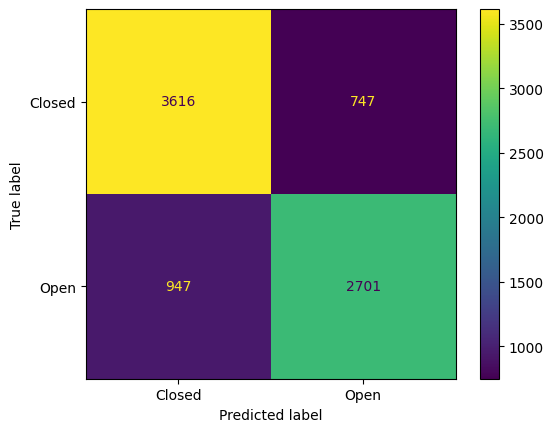

In [97]:
ConfusionMatrixDisplay.from_predictions(truths,preds[best_fold-1],display_labels=classes)

In [90]:
scores = []
for fold in folds:
    measurements = dict()
    measurements["roc_auc"] = roc_auc_score(truths, preds[int(fold)-1])
    measurements["pr_auc"] = average_precision_score(truths,preds[int(fold)-1])
    scores.append(measurements)
    

In [91]:
measurements_df = pd.DataFrame(
    data = scores,
    index = folds,
    columns = ['roc_auc', 'pr_auc']
)
measurements_df.to_csv(folder+"/metrics_df.csv", index_label="fold")

In [93]:
measurements_df

,roc_auc,pr_auc
1,0.733334,0.614004
2,0.642071,0.539080
3,0.597658,0.509651
4,0.604720,0.514103
5,0.654684,0.548139
6,0.743397,0.623552
7,0.604257,0.513789
8,0.665504,0.556119
9,0.635168,0.534258
10,0.784597,0.698211
